# Multi-level and Marginal Models - Linear and Logistic Regression

This notebook introduces multi-level and marginal models for linear and logistic regression. In contrast to ordinary linear and logistic regression, these models make the assumption that the variables are somehow correlated; that can be due to:

- Correlations within clusters; that happens when a clustered complex sample is done by dividing in neighborhoods, etc.
- Repeated measures along the time, typical in longitudinal studies that measure variable evolution during time.

Marginal and multi-level models differentiate from each other in these aspects:

- Multi-level models use random coefficients, i.e., variances between clusters (subject, neighborhood, etc.) are captured as random variables or effects; in addition to them, we also have the regular fixed effects or constant coefficients. All in all, the variance of the random effects is estimated. Thus, as a result, each cluster has its own model.
- Marginal models do not have random coefficients; instead, they have the regular linear/lohgistic regression parameters or coefficients. However, the variance between the variables is also computed to adjust the standard error of the coefficients. This allows for a more realistic inference (i.e., hypothesis testing or confidence interval computation). Additionally, that variance is computed overall, i.e., between-cluster variations are not computed, as it is done by multi-level models.

This notebook uses the dataset from this publication:

> Anderson, D., Oti, R., Lord, C., and Welch, K. (2009). Patterns of growth in adaptive social abilities among children with autism spectrum disorders. Journal of Abnormal Child Psychology, 37(7), 1019-1034.

Variables:

- AGE: the age of a child which (2-13).
- VSAE: child's socialization.
- SICDEGP: expressive language group at age two (1:low - 3:high).
- CHILDID: unique child ID.

Note that we have multiple measurements per child.

Overview of contents:

1. Multi-level Model
    - 1.1 Significance Testing - Comparison to Regular Linear Regression
2. Marginal Model
    - 2.1 Comparison of Model Parameters and Standard Errors

In [22]:
# Import the libraries that we will need for the analysis
import csv 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
import patsy
from scipy.stats import chi2 # for sig testing
from IPython.display import display, HTML # for pretty printing

In [23]:
# Read in the Autism Data
dat = pd.read_csv("autism.csv")
# Drop NA's from the data
dat = dat.dropna()

In [24]:
# Print out the first few rows of the data
dat.head()

,age,vsae,sicdegp,childid
0,2,6.0,3,1
1,3,7.0,3,1
2,5,18.0,3,1
3,9,25.0,3,1
4,13,27.0,3,1


In [25]:
dat.describe()

,age,vsae,sicdegp,childid
count,610.000000,610.000000,610.000000,610.000000
mean,5.770492,26.409836,1.959016,105.332787
std,3.974853,30.789810,0.762391,62.283496
min,2.000000,1.000000,1.000000,1.000000
25%,2.000000,10.000000,1.000000,48.250000
50%,4.000000,14.000000,2.000000,107.500000
75%,9.000000,27.000000,3.000000,158.000000
max,13.000000,198.000000,3.000000,212.000000


<AxesSubplot:xlabel='vsae', ylabel='Count'>

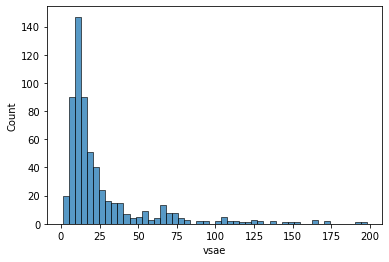

In [26]:
sns.histplot(dat['vsae'])

## 1. Multi-Level Model

In [27]:
# Build the model
# The formula follows the same syntax as in R
#   V1*V2 == V1 + V2 + V1V2
#   V1V2 is the interaction betweem variables, aka V1:V2
# C(): treat as categorical even though it is an integer
#   categorical variables are transformed into dummy variables: one binary variable per level
# re_formula: random effects formula
#   if we say '1 + age' the random intercept is computed, but it does not make sense
#   for ager = 0 to have any value, thus we remove the intercept;
#   besides, we'd have convergence issues
# I understand that the re_formula is the level 2 equation for the random effects?
mlm_mod = sm.MixedLM.from_formula(
    formula = 'vsae ~ age * C(sicdegp)', 
    groups = 'childid', 
    re_formula= "0 + age", 
    data=dat
)
# Run the fit
mlm_result = mlm_mod.fit()
# Print out the summary of the fit
mlm_result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   vsae      
No. Observations:   610       Method:               REML      
No. Groups:         158       Scale:                84.5319   
Min. group size:    1         Log-Likelihood:       -2427.0905
Max. group size:    5         Converged:            Yes       
Mean group size:    3.9                                       
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            2.482    1.271  1.952 0.051 -0.010  4.973
C(sicdegp)[T.2]     -1.293    1.674 -0.773 0.440 -4.574  1.987
C(sicdegp)[T.3]     -4.230    1.862 -2.272 0.023 -7.880 -0.580
age                  2.822    0.470  6.006 0.000  1.901  3.743
age:C(sicdegp)[T.2]  0.985    0.620  1.589 0.112 -0.230  2.199
age:C(sicdegp)[T.3]  4.463    0.688  6.482 0.000  3.113  5.812
age Var              8.198    0.124                           
==============================================================

"""

In [28]:
# Age as the variable is always dangerous in relation to the intercept
# Example: here, intercept can be interpreted as 
# the mean socialization 
# when a child in the first expressive language group is zero years old
# Thus, to improve the interpretation we center the variable
dat["age"] = dat.groupby("childid")["age"].transform(lambda x: x - x.mean())

In [29]:
# Print out the head of the dataset to see the centered measure
dat.head()

,age,vsae,sicdegp,childid
0,-4.4,6.0,3,1
1,-3.4,7.0,3,1
2,-1.4,18.0,3,1
3,2.6,25.0,3,1
4,6.6,27.0,3,1


In [31]:
# Refit the model, again, without the random intercepts
# Now, age is centered around 0
# But 0 means the original mean: 5.77
mlm_mod = sm.MixedLM.from_formula(
    formula = 'vsae ~ age * C(sicdegp)', 
    groups = 'childid', 
    re_formula="0 + age", 
    data=dat
)
# Run the fit
mlm_result = mlm_mod.fit()
# Print out the summary of the fit
mlm_result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   vsae      
No. Observations:   610       Method:               REML      
No. Groups:         158       Scale:                410.7496  
Min. group size:    1         Log-Likelihood:       -2752.2106
Max. group size:    5         Converged:            Yes       
Mean group size:    3.9                                       
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           17.421    1.470 11.848 0.000 14.539 20.303
C(sicdegp)[T.2]      6.359    1.942  3.274 0.001  2.552 10.166
C(sicdegp)[T.3]     23.403    2.157 10.852 0.000 19.176 27.630
age                  2.731    0.641  4.257 0.000  1.474  3.988
age:C(sicdegp)[T.2]  1.188    0.843  1.409 0.159 -0.465  2.840
age:C(sicdegp)[T.3]  4.555    0.931  4.891 0.000  2.730  6.381
age Var              9.609    0.112                           
==============================================================

"""

### 1.1 Significance Testing - Comparison to Regular Linear Regression

In [32]:
# Random Effects Mixed Model
mlm_mod = sm.MixedLM.from_formula(
    formula = 'vsae ~ age * C(sicdegp)', 
    groups = 'childid', 
    re_formula="0 + age", 
    data=dat
)

# OLS model - no mixed effects
ols_mod = sm.OLS.from_formula(
    formula = "vsae ~ age * C(sicdegp)",
    data = dat
)

# Run each of the fits
mlm_result = mlm_mod.fit()
ols_result = ols_mod.fit()

# Print out the summary of the fit
print(mlm_result.summary())
print(ols_result.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   vsae      
No. Observations:   610       Method:               REML      
No. Groups:         158       Scale:                410.7496  
Min. group size:    1         Log-Likelihood:       -2752.2106
Max. group size:    5         Converged:            Yes       
Mean group size:    3.9                                       
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           17.421    1.470 11.848 0.000 14.539 20.303
C(sicdegp)[T.2]      6.359    1.942  3.274 0.001  2.552 10.166
C(sicdegp)[T.3]     23.403    2.157 10.852 0.000 19.176 27.630
age                  2.731    0.641  4.257 0.000  1.474  3.988
age:C(sicdegp)[T.2]  1.188    0.843  1.409 0.159 -0.465  2.840
age:C(sicdegp)[T.3]  4.555    0.931  4.891 0.000  2.730  6.381
age V

## 2. Marginal Model

In [36]:
# Fit the exchangable covariance GEE
model_exch = sm.GEE.from_formula(
    formula = "vsae ~ age * C(sicdegp)",
    groups="childid",
    cov_struct=sm.cov_struct.Exchangeable(), 
    data=dat
    ).fit()

# Fit the independent covariance GEE
model_indep = sm.GEE.from_formula(
    "vsae ~ age * C(sicdegp)",
    groups="childid",
    cov_struct = sm.cov_struct.Independence(), 
    data=dat
    ).fit()

# We cannot fit an autoregressive model, but this is how 
# we would fit it if we had equally spaced ages
# model_indep = sm.GEE.from_formula(
#     "vsae ~ age * C(sicdegp)",
#     groups="age",
#     cov_struct = sm.cov_struct.Autoregressive(), 
#     data=dat
#     ).fit()

### 2.1 Comparison of Model Parameters and Standard Errors

In [37]:
# Construct a datafame of the parameter estimates
# and their standard errors
x = pd.DataFrame(
    {
        "OLS_Params": ols_result.params,
        "OLS_SE": ols_result.bse,
        "MLM_Params": mlm_result.params,
        "MLM_SE": mlm_result.bse,
        "GEE_Exch_Params": model_exch.params, 
        "GEE_Exch_SE": model_exch.bse,
        "GEE_Indep_Params": model_indep.params, 
        "GEE_Indep_SE": model_indep.bse
    }
)
# Ensure the ordering is logical
x = x[["OLS_Params", "OLS_SE", "MLM_Params", "MLM_SE", "GEE_Exch_Params", 
       "GEE_Exch_SE", "GEE_Indep_Params", "GEE_Indep_SE"]]
# Round the results of the estimates to two decimal places
x = np.round(x, 2)
# Print out the results in a pretty way
display(HTML(x.to_html()))

,OLS_Params,OLS_SE,MLM_Params,MLM_SE,GEE_Exch_Params,GEE_Exch_SE,GEE_Indep_Params,GEE_Indep_SE
C(sicdegp)[T.2],6.36,2.24,6.36,1.94,5.64,2.95,6.36,2.88
C(sicdegp)[T.3],23.40,2.48,23.40,2.16,22.65,3.55,23.40,3.45
Intercept,17.42,1.69,17.42,1.47,17.59,1.99,17.42,1.91
age,2.60,0.46,2.73,0.64,2.60,0.51,2.60,0.51
age Var,NaN,NaN,0.02,0.01,NaN,NaN,NaN,NaN
age:C(sicdegp)[T.2],1.47,0.60,1.19,0.84,1.47,0.78,1.47,0.78
age:C(sicdegp)[T.3],4.48,0.66,4.56,0.93,4.48,0.88,4.48,0.88
